<a href="https://colab.research.google.com/github/TairCohen/personal-nutritionist-agent/blob/tair/basic_agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [80]:
!pip install -q langgraph
!pip install -q --upgrade langchain-text-splitters langchain-community langgraph
!pip install -q langchain-openai
!pip install faiss-cpu>=1.7.4
!pip install -q langchain

In [78]:
import os
from google.colab import userdata
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
llm = ChatOpenAI(model="gpt-4-turbo")

In [114]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from google.colab import files
from PIL import Image as PIL_Image
from pprint import pprint
import base64
from io import BytesIO
import pandas as pd
from langchain_community.document_loaders.csv_loader import CSVLoader
import faiss
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain_community.vectorstores import FAISS
from google.colab import drive
from langchain_core.prompts import ChatPromptTemplate
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain


class State(MessagesState):
    summary: str
    img_name: str
    img_base64: str
    img_interpertation: str
    # documents: list

# System message
sys_msg = SystemMessage(content="You are an AI nutrition assistant that estimates the total calories in a dish based on a text description or an image")

def assistant(state: State):
  ai_message = [AIMessage("Got a dish in mind? Upload a photo, and I’ll estimate how many calories it contains!", name="Bot")]
  print(ai_message)
  return {"messages": [llm.invoke([sys_msg] + ai_message)]}


def upload_image(state: State):
  uploaded = files.upload()
  for name, file in uploaded.items():
      print(f"Uploaded file: {name}")
      return {"img_name": name}

def display_image(state: State):
  for m in state["messages"]:
    m.pretty_print()

  name = state["img_name"]
  img = PIL_Image.open(name)
  display(img)
  # Convert image to bytes buffer
  buffered = BytesIO()
  img.save(buffered, format="JPEG")  # or "PNG", depending on input
  img_bytes = buffered.getvalue()
  # Encode to Base64
  img_base64 = base64.b64encode(img_bytes).decode('utf-8')
  return {"img_base64": img_base64}


# Function to identify food from an image
def identify_food(state: State):
  img_base64 = state["img_base64"]
  sys_task = ("Give only a list of the ingredients that make up the dish in the picture."
    " and for each ingredient, give its weight in grams for the dish in the picture.")
  response = llm.invoke([
      HumanMessage(
          content=[
              {"type": "text", "text": sys_task},
              {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{img_base64}"}}
          ]
      )
  ])
  print(response.pretty_print())
  return {"messages": response, "img_interpertation": response.content}

def get_retriever():
  drive.mount('/content/drive')
  filtered_file_path = "/content/drive/MyDrive/סיכומים מתואר שני/NLP/calories_dataset_consistent_rephrasing.csv"
  # filtered_file_path = "/content/drive/MyDrive/סיכומים מתואר שני/NLP/calories_ds_filtered_data.csv"
  data = pd.read_csv(filtered_file_path)
  docs = CSVLoader(file_path=filtered_file_path).load_and_split()
  embeddings = OpenAIEmbeddings()
  index = faiss.IndexFlatL2(len(OpenAIEmbeddings().embed_query(" ")))
  vector_store = FAISS(
      embedding_function=OpenAIEmbeddings(),
      index=index,
      docstore=InMemoryDocstore(),
      index_to_docstore_id={}
  )
  vector_store.add_documents(documents=docs)
  retriever = vector_store.as_retriever()
  return retriever

def get_rag():
  retriever = get_retriever()
  # Set up system prompt
  system_prompt = (
      "You are an AI nutrition assistant that estimates the total calories in a dish based on a text description or an image.\n\n"
      "### *Estimation Methodology:*\n"
      "1. *Check for an exact match in the database.*\n"
      "   - If an exact match exists, return its calorie count per 100g.\n"
      "2. *If no exact match exists, break the dish into ingredients and estimate calories.*\n"
      "   - Identify the *most relevant base food* (e.g., a plain omelet for 'cheese omelet').\n"
      "   - Check for *similar variations* (e.g., 'Egg or omelet, fried without oil' as the base).\n"
      "   - *Only include ingredients explicitly mentioned in the description.*\n"
      "   - Add ingredients like cheese based on the closest match in the database. *Do not assume any extra ingredients (e.g., mushrooms) unless explicitly mentioned.*\n"
      "   - Adjust calorie estimates proportionally to the expected ingredient ratio.\n"
      "3. *Do NOT assume extra ingredients unless explicitly mentioned.*\n"
      "4. *Do NOT use the calorie value of a mixed dish (e.g., 'omelet with mushrooms and cheese') as a direct replacement for a different variant (e.g., 'cheese omelet').*\n"
      "5. *Clearly explain the steps taken, including any assumptions about portions.*\n"
      "6. *For each ingredient:*\n"
      "   - Provide the closest match from the database (e.g., 'Egg or omelet, fried without oil') and its calorie count per 100g.\n"
      "   - If the exact calorie count for an ingredient is missing, explain that and provide an estimated serving size (e.g., 150g for eggs, 30g for cheese).\n"
      "   - Use the standard serving size to calculate the calories from each ingredient based on the proportion of the total dish.\n"
      "7. *Provide the final total calories for the dish.*\n\n"
      "Use the retrieved database context below to find accurate calorie values:\n"
      "{context}\n\n"
      "If the exact ingredient is not found, use the closest alternative and explain why.\n"
      "If specific calorie counts are missing, make assumptions based on standard serving sizes and ingredient ratios. Always provide the final total calorie estimate.")


  prompt = ChatPromptTemplate.from_messages([
      ("system", system_prompt),
      ("human", "{input}"),

  ])

  # Create the question-answer chain
  question_answer_chain = create_stuff_documents_chain(llm, prompt)
  rag_chain = create_retrieval_chain(retriever, question_answer_chain)
  return rag_chain

def get_calories(state: State):
  food_items = state["img_interpertation"]
  rag_chain = get_rag()
  response = rag_chain.invoke({"input": f"How much food energy is in {food_items}?"})
  print(response['answer'])


In [115]:
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("assistant", assistant)
workflow.add_node("upload_image", upload_image)
workflow.add_node("display_image", display_image)
workflow.add_node("identify_food", identify_food)
workflow.add_node("get_calories", get_calories)


# Set the entrypoint as conversation
workflow.add_edge(START, "assistant")
workflow.add_edge("assistant", "upload_image")
workflow.add_edge("upload_image", "display_image")
workflow.add_edge("display_image", "identify_food")
workflow.add_edge("identify_food", "get_calories")
workflow.add_edge("get_calories", END)


# Compile
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
# display(Image(graph.get_graph().draw_mermaid_png()))


[AIMessage(content='Got a dish in mind? Upload a photo, and I’ll estimate how many calories it contains!', additional_kwargs={}, response_metadata={}, name='Bot')]


Saving download.jpg to download (30).jpg
Uploaded file: download (30).jpg
================================== Ai Message ==================================

Sorry, I currently can't process images. Please provide a description of the dish, and I'll help estimate the calories based on the information you give.


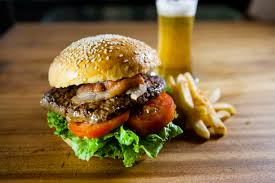

================================== Ai Message ==================================

The dish in the picture is a hamburger with fries. Here's a general list of ingredients usually found in such a meal, along with an estimated weight for each ingredient in the dish pictured:

1. Hamburger bun - 70 grams
2. Ground beef patty - 120 grams
3. Slice of cheese - 20 grams
4. Lettuce leaves - 30 grams
5. Tomato slices - 40 grams
6. Onion slices - 25 grams
7. Bacon strips - 20 grams
8. French fries - 150 grams

These are estimates and can vary depending on the specific recipe or serving size at different restaurants or homemade versions.
None
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
To calculate the total food energy of this hamburger with fries based on the given ingredients, we'll match each component to the closest food item available in the database or a standard reference when necessary, and then sum up th

In [116]:
config = {"configurable": {"thread_id": "1"}}
# input_message = HumanMessage(content="hi! I'm Lance")
# output = graph.invoke({"messages": [input_message]}, config)
output = graph.invoke({}, config)

In [ ]:

# טוענים תמונה מהזיכרון
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")

# קריאה לקובץ תמונה
image_path = Path("/content/2.jpg")
image_base64 = encode_image(image_path)

# מגדירים את ה-State
class ChatState(TypedDict):
    age: Optional[int]
    gender: Optional[str]
    weight: Optional[float]
    goal: Optional[str]
    meal_photo: Optional[str]  # שימי לב: str ולא bytes
    meal_analysis: Optional[str]

# פונקציות זרימה
def ask_age(state: ChatState):
    age = int(input("👤 Enter your age: "))
    return {"age": age}

def ask_gender(state: ChatState):
    gender = input("🚻 Enter your gender (male/female): ")
    return {"gender": gender}

def ask_weight(state: ChatState):
    weight = float(input("⚖️ Enter your weight (kg): "))
    return {"weight": weight}

def ask_goal(state: ChatState):
    print("🎯 Choose your goal:")
    print("1 - Weight Loss")
    print("2 - Muscle Gain")
    print("3 - Maintenance")
    choice = input("Enter 1/2/3: ")
    goal = {"1": "weight_loss", "2": "muscle_gain", "3": "maintenance"}.get(choice, "maintenance")
    return {"goal": goal}

def upload_meal_photo(state: ChatState):
    return {"meal_photo": image_base64}

def analyze_food_simple(image_base64):

    response = openai.ChatCompletion.create(
        model="gpt-4-turbo",
        messages=[
            {"role": "system", "content": "You are a nutrition expert who knows how to estimate the caloric values ​​of various dishes. You analyze a picture of a dish and estimate the weight in grams for each of the ingredients that make up the dish."},
            {"role": "user", "content": [
                {"type": "text", "text": "Give only a list of the ingredients that make up the dish in the picture and for each ingredient, give its weight in grams for the dish in the picture."},
                {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{image_base64}"}}
            ]}
        ],
        max_tokens=500
    )
    return response["choices"][0]["message"]["content"]

def handle_meal_analysis(state: ChatState):
    analysis = analyze_food_simple(state["meal_photo"])
    print("\n🔎 Analysis Completed:")
    print(analysis)
    return {"meal_analysis": analysis}

# גרף
graph = StateGraph(ChatState)

graph.add_node("AskAge", ask_age)
graph.add_node("AskGender", ask_gender)
graph.add_node("AskWeight", ask_weight)
graph.add_node("AskGoal", ask_goal)
graph.add_node("UploadMealPhoto", upload_meal_photo)
graph.add_node("HandleMealAnalysis", handle_meal_analysis)

graph.set_entry_point("AskAge")
graph.add_edge("AskAge", "AskGender")
graph.add_edge("AskGender", "AskWeight")
graph.add_edge("AskWeight", "AskGoal")
graph.add_edge("AskGoal", "UploadMealPhoto")
graph.add_edge("UploadMealPhoto", "HandleMealAnalysis")
graph.add_edge("HandleMealAnalysis", END)

# מריצים
app = graph.compile()

result = app.invoke({})

print("\n🍽️ Final Meal Analysis:")
print(result["meal_analysis"])


KeyboardInterrupt: Interrupted by user

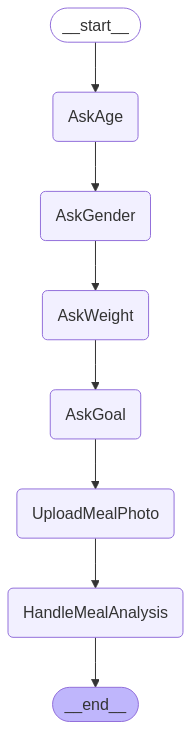

In [ ]:
from IPython.display import Image
# Show
display(Image(app.get_graph(xray=True).draw_mermaid_png()))